# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [3]:
def Q1(num_examples=5):
    ### STUDENT START ###
    for k in range(num_examples):
        print(f"Example #{k+1}")
        print("\nMessage: ", train_data[k])
        print("\nLabel:", newsgroups_train.target_names[train_labels[k]])
        print("-"*50)
    ### STUDENT END ###

Q1(5)

Example #1

Message:  Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Label: comp.graphics
--------------------------------------------------
Example #2

Message:  

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [4]:
def Q2():
    ### STUDENT START ###
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    print(f"Size of vocabulary is {X.shape[1]}")
    print(f"Average number of non-zero features per example: {X.nnz/X.shape[0]:.2f}")
    print(f"Fraction of number of non-zero entries in the matrix: {X.nnz}/{(X.shape[0]*X.shape[1])}")
    print(f"First feature: {vectorizer.get_feature_names()[0]}")
    print(f"Last feature: {vectorizer.get_feature_names()[-1]}")
    
    vectorizer_with_vocab = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"])
    X2 = vectorizer_with_vocab.transform(train_data)
    print(f"Size of vocabulary with set vocab is {X2.shape[1]}")
    
    vectorizer_with_ngram = CountVectorizer(analyzer='char', ngram_range=(2,3))
    X3 = vectorizer_with_ngram.fit_transform(train_data)
    print(f"Size of vocabulary with characters is {X3.shape[1]}")
    
    vectorizer_with_prune = CountVectorizer(min_df=10)
    X4 = vectorizer_with_prune.fit_transform(train_data)
    print(f"Size of vocabulary with pruning is {X4.shape[1]}")
    
    vectorizer_train = CountVectorizer()
    vectorizer_dev =  CountVectorizer()
    X_train = vectorizer_train.fit_transform(train_data)
    X_dev = vectorizer_dev.fit_transform(dev_data)
    print(f"Dev vocab is missing {X_train.shape[1] - X_dev.shape[1]}/{X_train.shape[1]} of the training vocabulary")
    ### STUDENT END ###

Q2()

Size of vocabulary is 26879
Average number of non-zero features per example: 96.71
Fraction of number of non-zero entries in the matrix: 196700/54671886
First feature: 00
Last feature: zyxel
Size of vocabulary with set vocab is 4
Size of vocabulary with characters is 35478
Size of vocabulary with pruning is 3064
Dev vocab is missing 10633/26879 of the training vocabulary


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def Q3():
    ### STUDENT START ###
    vectorizer = CountVectorizer()
    train_transformed = vectorizer.fit_transform(train_data)
    dev_transformed = vectorizer.transform(dev_data)
    print("K Nearest Neighbors Models")
    num_knn_models = 20
    for k in range(1,num_knn_models + 1):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(train_transformed, train_labels)
        predicted_labels = model.predict(dev_transformed) 

        f1_score = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
        print(f"k={k:3} has f1_score of {f1_score*100:.2f}%")
    print("Optimal k is 7")
    
    print("\nNaive Bayes Models")
    alphas = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    for alpha_test in alphas:
        model = MultinomialNB(alpha=alpha_test)
        model.fit(train_transformed, train_labels)
        predicted_labels = model.predict(dev_transformed) 
        f1_score = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
        print(f"alpha = {alpha_test:6} has f1_score of {f1_score*100:.2f}%")

    print("Optimal alpha is 0.1")
    
    print("\nLogistic Regression Models")
    C_values = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    for C_val in C_values:
        model = LogisticRegression(C=C_val, solver="liblinear", multi_class="auto")
        model.fit(train_transformed, train_labels)
        predicted_labels = model.predict(dev_transformed) 

        f1_score = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
        weights = model.coef_
        ssw = np.sum(weights**2,axis=1)
        print(f"C={C_val:3} has f1_score of {f1_score*100:.2f}%")
        print(f"Sum of squared weights for each topic are {ssw[0]:.2f} {ssw[1]:.2f} {ssw[2]:.2f} {ssw[3]:.2f}\n")
    print("Optimal C is 0.5")
    
    ### STUDENT END ###

Q3()

K Nearest Neighbors Models
k=  1 has f1_score of 38.05%
k=  2 has f1_score of 38.05%
k=  3 has f1_score of 40.84%
k=  4 has f1_score of 40.31%
k=  5 has f1_score of 42.88%
k=  6 has f1_score of 44.67%
k=  7 has f1_score of 45.05%
k=  8 has f1_score of 44.70%
k=  9 has f1_score of 43.66%
k= 10 has f1_score of 42.79%
k= 11 has f1_score of 42.66%
k= 12 has f1_score of 42.11%
k= 13 has f1_score of 42.40%
k= 14 has f1_score of 42.24%
k= 15 has f1_score of 43.26%
k= 16 has f1_score of 43.44%
k= 17 has f1_score of 44.86%
k= 18 has f1_score of 43.19%
k= 19 has f1_score of 43.66%
k= 20 has f1_score of 42.43%
Optimal k is 7

Naive Bayes Models
alpha =  1e-10 has f1_score of 74.72%
alpha = 0.0001 has f1_score of 76.28%
alpha =  0.001 has f1_score of 77.03%
alpha =   0.01 has f1_score of 77.52%
alpha =    0.1 has f1_score of 79.03%
alpha =    0.5 has f1_score of 78.63%
alpha =    1.0 has f1_score of 77.77%
alpha =    2.0 has f1_score of 76.90%
alpha =   10.0 has f1_score of 66.75%
Optimal alpha is

ANSWER: k-Nearesest Neighbors doesn't work well for this problem because it is hard to cluster the observations with a feature space that is so large.

Logistic Regression doesn't work as well as Naive Bayes because NB sets its weights independently for each feature while logistic regression sets all of its weights together. Because the model has to fit to a large feature space, naive bayes is more accurate in its predictions.

The relationship between logistic regression's sum of squared weights and C value is proportional. The higher the C value, the larger the sum of squared weights. 

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [6]:
def Q4():
    ### STUDENT START ###
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2))
    X = vectorizer.fit_transform(train_data)
    model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    model.fit(X, train_labels)
    topics = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
    full_feature_list = []
    final_feature_list = []

    for count, topic in enumerate(topics):
        topic_feature_list = []
        sorted_labels = np.argsort(model.coef_[count])
        ind = sorted_labels[-5:]
        topic_feature_list = [vectorizer.get_feature_names()[k] for k in ind]
        for val in topic_feature_list:
            full_feature_list.append(val)

    final_feature_list = []
    for val in full_feature_list:
        if val not in final_feature_list:
            final_feature_list.append(val)

    full_feature_list_with_ceof = []
    for feature in final_feature_list:
        feature_ind = vectorizer.vocabulary_[feature]
        coef_list = model.coef_[:,feature_ind].tolist()
        feature_list = [feature]
        feature_list.extend(coef_list)
        full_feature_list_with_ceof.append(feature_list)
    
    print ("{:<13} {:>15} {:>15} {:>15} {:>15}".format('Feature','Alt Weight','Talk Weight', 'Comp Weight', 'Sci Weight'))
    print("-"*77)
    for feat in full_feature_list_with_ceof:
        feature, coef_alt, coef_talk, coef_comp, coef_sci = feat
        print("{:<13} {:15.5f} {:15.5f} {:15.5f} {:15.5f}".format(feature, coef_alt, coef_talk, coef_comp, coef_sci))
    ### STUDENT END ###

Q4()

Feature            Alt Weight     Talk Weight     Comp Weight      Sci Weight
-----------------------------------------------------------------------------
are you               0.44695        -0.24826        -0.09717        -0.30562
you are               0.47274        -0.27991        -0.48143         0.02837
was just              0.48205        -0.13142        -0.12886        -0.22746
cheers kent           0.55572        -0.69790        -0.66378         0.53481
claim that            0.60555        -0.19904        -0.27438        -0.14037
is there             -0.34088         0.75498        -0.46825        -0.25708
out there            -0.27480         0.75868        -0.47900        -0.27709
comp graphics        -0.29217         0.80120        -0.37092        -0.28518
in advance           -0.45935         0.83257        -0.43849        -0.41845
looking for          -0.63034         1.10837        -0.49993        -0.57186
it was               -0.20303        -0.30966         0.52534   

ANSWER: The most surprising features in this table are the ones that are very broad and non-descriptive. Many of the features seem like they are terms that are used in many different contexts, and not specifically aimed toward one topic.

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [7]:
def Q5():
    ### STUDENT START ###
    # No Preprocessing
    def empty_function(text):
        return text
    vectorizer = CountVectorizer(preprocessor=empty_function)
    train_transformed = vectorizer.fit_transform(train_data)
    dev_transformed = vectorizer.transform(dev_data)
    model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    model.fit(train_transformed, train_labels)
    predicted_labels = model.predict(dev_transformed) 
    f1_nonproc = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
    nonproc_vocab_size = len(vectorizer.vocabulary_)
    print("Nonprocessed data")
    print(f"f1 score: {f1_nonproc:.4}")
    print(f"Vocab size: {nonproc_vocab_size}")
    
    # With Preprocessing
    def processing_function(text):
        processed_text = text.lower()
        processed_text =re.sub("\\W"," ",processed_text)
        processed_text =re.sub("\\s+(in|the|all|for|and|on|was|but|of|i|me|myself|we|our|ours|you|your|he|him|his|she|her|hers|it|they|them|their|what|which|who||this|that|that|these|those|am|is|are|were|been|being|has|had|do|does|did|a|an|if|or|with|about|because|such|as|while|until|at|by|with|into|through|during|before)\\s+"," _connector_ ",processed_text) # normalize certain words
        return processed_text
    
    analyzer = CountVectorizer().build_analyzer()
    ps = nltk.stem.PorterStemmer()

    def stemmed_words(doc):
        return (ps.stem(w) for w in analyzer(doc))

    vectorizer = CountVectorizer(preprocessor=processing_function, analyzer=stemmed_words,max_df=0.35)
    train_transformed = vectorizer.fit_transform(train_data)
    dev_transformed = vectorizer.transform(dev_data)
    model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    model.fit(train_transformed, train_labels)
    predicted_labels = model.predict(dev_transformed) 
    f1_proc = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
    proc_vocab_size = len(vectorizer.vocabulary_)

    print("\nProcessed data")
    print(f"f1 score: {f1_proc:.4}")
    print(f"Vocab size: {proc_vocab_size}")  
    print(f"\nVocabulary decreased by {nonproc_vocab_size - proc_vocab_size} words")
    ### STUDENT END ###

Q5()

Nonprocessed data
f1 score: 0.7069
Vocab size: 33291

Processed data
f1 score: 0.7221
Vocab size: 19656

Vocabulary decreased by 13635 words


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

C = 0.1 -> Vocab size:  218 -> f1 score: 0.69983
C = 0.2 -> Vocab size:  367 -> f1 score: 0.68567
C = 0.3 -> Vocab size:  520 -> f1 score: 0.67661
C = 0.4 -> Vocab size:  673 -> f1 score: 0.68035
C = 0.5 -> Vocab size:  752 -> f1 score: 0.6649
C = 0.6 -> Vocab size:  836 -> f1 score: 0.6718
C = 0.7 -> Vocab size:  933 -> f1 score: 0.67776
C = 0.8 -> Vocab size:  959 -> f1 score: 0.67222
C = 0.9 -> Vocab size: 1051 -> f1 score: 0.68078
C =   1 -> Vocab size: 1099 -> f1 score: 0.69372


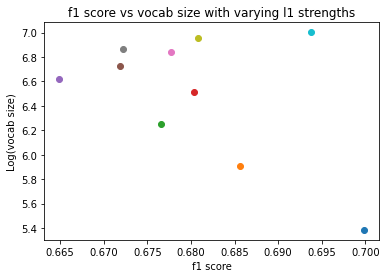

In [8]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    l1_strengths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    plotting_list = []
    vectorizer = CountVectorizer()
    train_transformed = vectorizer.fit_transform(train_data)
    dev_transformed = vectorizer.transform(dev_data)
    for strength in l1_strengths:
        model1 = LogisticRegression(C=strength, solver="liblinear", multi_class="auto", tol=0.015, penalty="l1")
        model1.fit(train_transformed, train_labels)
        new_vocab_ind = np.any(model1.coef_,axis=0)
        new_train_data = train_transformed[:,new_vocab_ind]
        new_dev_data = dev_transformed[:,new_vocab_ind]
        new_vocab_size = np.count_nonzero(new_vocab_ind)
        predicted_labels = model1.predict(dev_transformed) 
        f1_l1 = metrics.f1_score(dev_labels, predicted_labels, average="weighted")

        model2 = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", tol=0.015, penalty="l2")
        model2.fit(new_train_data, train_labels)
        predicted_labels = model2.predict(new_dev_data) 
        f1_l2 = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
        vocab_size = len(vectorizer.vocabulary_)
        plotting_list.append((f1_l2, new_vocab_size))
        print(f"C = {strength:3} -> Vocab size: {new_vocab_size:4} -> f1 score: {f1_l2:.5}")
    plt.figure()
    plt.xlabel("f1 score")
    plt.ylabel("Log(vocab size)")
    plt.title("f1 score vs vocab size with varying l1 strengths")
    for (f1, vocab_size) in plotting_list: 
        plt.scatter(f1, np.log(vocab_size))
    plt.show()
    ### STUDENT END ###

Q6()

ANSWER: The performance of the models based on reduced vocabularies compared to the models based on full vocabulary vary across the different l1 strengths. In most cases, the f1 score is slighter higher for the models based on full vocabularies. This difference is so small in most cases, but the computation requirements are much lower with the reduced vocabularies. The only case when the larger vocabulary performed worse was when C=0.1, so the l1 regularization did not have a lot of pull on the weights.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
def Q7():
    ### STUDENT START ###
    vectorizer = TfidfVectorizer()
    train_transformed = vectorizer.fit_transform(train_data)
    dev_transformed = vectorizer.transform(dev_data)
    
    model = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty="l2")
    model.fit(train_transformed, train_labels)
    predicted_labels = model.predict(dev_transformed)

    f1 = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
    print(f"f1 score of the model using data in Tfidf form is {f1:.5f}")
    prob_predictions = model.predict_proba(dev_transformed)
    
    R_list = []
    for count, doc in enumerate(prob_predictions):
        label = dev_labels[count]
        correct_prediction = doc[label]
        highest_prediction = max(doc)
        R_val = highest_prediction/correct_prediction
        R_list.append(R_val)
        
    sorted_R = np.argsort(R_list)    
    top_3_docs = sorted_R[-3:]
    for count, doc_num in enumerate(top_3_docs):
        R_val = R_list[doc_num]
        print("-"*50)
        print(f"Doc #{doc_num} with R ratio: {R_val:.3f}")
        print("\nMessage: ", dev_data[count])
        
    ### STUDENT END ###

Q7()

f1 score of the model using data in Tfidf form is 0.75977
--------------------------------------------------
Doc #607 with R ratio: 287.180

Message:  TRry the SKywatch project in  Arizona.
--------------------------------------------------
Doc #665 with R ratio: 325.004

Message:  The Vatican library recently made a tour of the US.
 Can anyone help me in finding a FTP site where this collection is 
 available.
--------------------------------------------------
Doc #215 with R ratio: 929.358

Message:  Hi there,

I am here looking for some help.

My friend is a interior decor designer. He is from Thailand. He is
trying to find some graphics software on PC. Any suggestion on which
software to buy,where to buy and how much it costs ? He likes the most
sophisticated 
software(the more features it has,the better)


ANSWER: The R ratio describes the degree of which the prediction is incorrect. The higher, the R ratio, the higher the predictions confidence in a wrong label.

The model is making a mistake when there is not a lot of relevant content for the main topic. Many of the words in these messages correlate with another topic, but there are a few words that set up the rest of the message. Because the majority of the message does not correlate with the correct topic, a min_df parameter could be implemented in the TfidfVectorizer. This will help guide the model away from outliars that are only present in a small percentage of the documents. 

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.

In [10]:
vectorizer = TfidfVectorizer(min_df=0.4)
train_transformed = vectorizer.fit_transform(train_data)
dev_transformed = vectorizer.transform(dev_data)

model = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty="l2")
model.fit(train_transformed, train_labels)
predicted_labels = model.predict(dev_transformed)

f1 = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
print(f"f1 score of the model using data in Tfidf form is {f1:.5f}")
prob_predictions = model.predict_proba(dev_transformed)

R_list = []
for count, doc in enumerate(prob_predictions):
    label = dev_labels[count]
    correct_prediction = doc[label]
    highest_prediction = max(doc)
    R_val = highest_prediction/correct_prediction
    R_list.append(R_val)

sorted_R = np.argsort(R_list)    
top_3_docs = sorted_R[-3:]
for count, doc_num in enumerate(top_3_docs):
    R_val = R_list[doc_num]
    print("-"*50)
    print(f"Doc #{doc_num} with R ratio: {R_val:.3f}")
    print("\nMessage: ", dev_data[count])


f1 score of the model using data in Tfidf form is 0.39014
--------------------------------------------------
Doc #471 with R ratio: 16.272

Message:  TRry the SKywatch project in  Arizona.
--------------------------------------------------
Doc #67 with R ratio: 16.288

Message:  The Vatican library recently made a tour of the US.
 Can anyone help me in finding a FTP site where this collection is 
 available.
--------------------------------------------------
Doc #507 with R ratio: 16.771

Message:  Hi there,

I am here looking for some help.

My friend is a interior decor designer. He is from Thailand. He is
trying to find some graphics software on PC. Any suggestion on which
software to buy,where to buy and how much it costs ? He likes the most
sophisticated 
software(the more features it has,the better)


ANSWER: While these predictions are still wrong, the R ratio's are significantly smaller than before. This extra parameter caused the model to be less confident in it's incorrect predicitions.